In [2]:
# Required libraries
from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np # Import the Numpy package
from cpt_convert import loadCPT # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps
from datetime import datetime
from glob import glob
import os
from utils import *
from scipy.ndimage import interpolation

# Converts the CPT file to be used in Python
cpt = loadCPT('IR4AVHRR6.cpt')
# Makes a linear interpolation with the CPT file
cpt_convert = LinearSegmentedColormap('cpt', cpt)

In [58]:
path = '/Users/thd5tt/Downloads/sat/'


fname=path+"W_XX-EUMETSAT-Darmstadt,VIS+IR+HRV+IMAGERY,MSG2+SEVIRI_C_EUMG_20200916115510.nc"
#fname=path+"W_XX-EUMETSAT-Darmstadt,VIS+IR+HRV+IMAGERY,MSG2+SEVIRI_C_EUMG_20200916051010.nc"
# fname=path+"W_XX-EUMETSAT-Darmstadt,VIS+IR+HRV+IMAGERY,MSG2+SEVIRI_C_EUMG_20200916055010.nc"

# Search for the Scan Start in the file name
time = (fname[fname.find("MG_")+3:fname.find(".nc")])
# Format the "Observation Start" string
date = datetime.strptime(time,'%Y%m%d%H%M%S')

# Check if we already created the image
image_string= path+'images/'+datetime.strftime(date,'%Y%m%d%H%M%S')+'.png'

print('Using '+fname)
# Open the file using the NetCDF4 library
nc = Dataset(fname)
# Extract the Brightness Temperature values from the NetCDF    

temp_b = brigthness_temp(nc.variables['ch9'])
    
temp_b_masked = np.ma.masked_array(temp_b, temp_b < -80)
hrv =  nc.variables['ch12'][:]

lons = np.ma.masked_less(nc.variables['lon'][:], -180)
lats = np.ma.masked_less(nc.variables['lat'][:], -90)

lats_hrv, lons_hrv = create_coord_hrv(lats, lons)

Using /Users/thd5tt/Downloads/sat/W_XX-EUMETSAT-Darmstadt,VIS+IR+HRV+IMAGERY,MSG2+SEVIRI_C_EUMG_20200916115510.nc


In [52]:
hrv.std()

1.1721858861943841

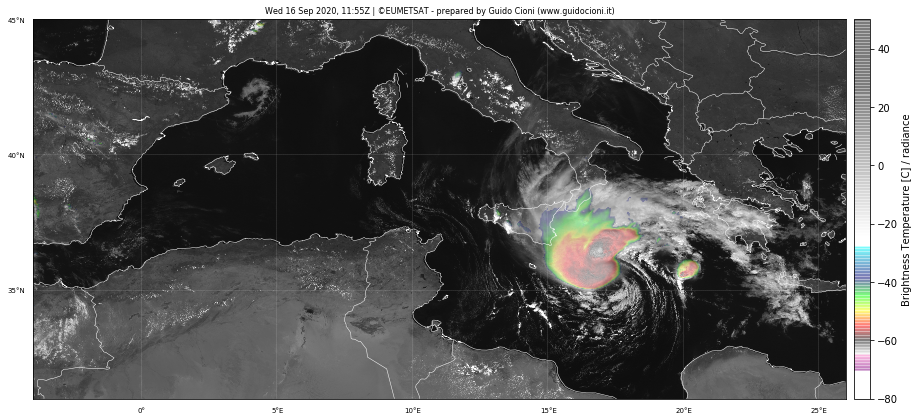

In [69]:
fig = plt.figure(figsize=(15, 15))

bmap = Basemap(projection='cyl', llcrnrlon=-4, llcrnrlat=31, 
               urcrnrlon=26, urcrnrlat=45, resolution='i')

x,y = bmap(lons,lats)
x_hrv, y_hrv = bmap(lons_hrv, lats_hrv)

# if (hrv.std() > 0.9):
#     bmap.pcolormesh(x_hrv, y_hrv, hrv, vmin=0, vmax=20, cmap='gray')
# elif (0.8 <= hrv.std() <= 0.9):
bmap.pcolormesh(x_hrv, y_hrv, hrv, vmin=0, vmax=20, cmap='gray')
bmap.pcolormesh(x, y, np.ma.masked_array(temp_b, temp_b > -38),
                vmin=-80, vmax=50, cmap=cpt_convert,
                alpha=0.3, linewidth=0, antialiased=True)
# else:
#     bmap.pcolormesh(x, y, temp_b, vmin=-80, vmax=50, cmap=cpt_convert)
    
bmap.drawcoastlines(linewidth=0.5, linestyle='solid', color='white')
bmap.drawcountries(linewidth=0.5, linestyle='solid', color='white')
bmap.drawparallels(np.arange(-90.0, 90.0, 5.), linewidth=0.2, color='white',
                   labels=[True, False, False, True], fontsize=7)
bmap.drawmeridians(np.arange(0.0, 360.0, 5.), linewidth=0.2, color='white',
                   labels=[True, False, False, True], fontsize=7)

# Insert the legend
bmap.colorbar(location='right', label='Brightness Temperature [C] / radiance', size='2%', pad='1%')
date_formatted = datetime.strftime(date,'%a %d %b %Y, %H:%MZ')
plt.title(date_formatted+" | "+u"\N{COPYRIGHT SIGN}"+'EUMETSAT - prepared by Guido Cioni (www.guidocioni.it)',
          fontsize=8)
plt.savefig('test_merge.png', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
path = '/work/mh0731/m300382/sat/ilona/'

fnames=sorted(glob(path+"*.nc"))
first=True
coords=[]

for fname in fnames[35:340]:
    # Search for the Scan Start in the file name
    time = (fname[fname.find("MG_")+3:fname.find(".nc")])
    # Format the "Observation Start" string
    date = datetime.strptime(time,'%Y%m%d%H%M%S')

    image_string='./images/'+datetime.strftime(date,'%Y%m%d%H%M%S')+'.png'

    print('Using '+fname)
    # Open the file using the NetCDF4 library
    nc = Dataset(fname)
    # Extract the Brightness Temperature values from the NetCDF    
    temp_b = brigthness_temp(nc.variables['ch9'])
    
    if first:
        lons = np.ma.masked_less(nc.variables['lon'][:], -180)
        lats = np.ma.masked_less(nc.variables['lat'][:], -90)
        bmap = Basemap(projection='cyl', llcrnrlon=-8, llcrnrlat=35, urcrnrlon=21, urcrnrlat=45, resolution='i')
        # Draw the coastlines, countries, parallels and meridians
        x,y = bmap(lons,lats)
        first = False 

    # Get coordinates on click
    i = 0
    def onclick(event):
        global ix, iy
        ix, iy = event.xdata, event.ydata
        coords.append((ix, iy))
        print("clicked "+str(coords))
        plt.clf()

    plt.ion()
    fig = plt.figure(figsize=(15, 15))

    bmap.pcolormesh(x, y, temp_b, vmin=-80, vmax=30, cmap=cpt_convert)
    bmap.drawcoastlines(linewidth=0.5, linestyle='solid', color='white')
    bmap.drawcountries(linewidth=0.5, linestyle='solid', color='white')
    bmap.drawparallels(np.arange(-90.0, 90.0, 5.), linewidth=0.2, color='white',
                       labels=[True, False, False, True], fontsize=7)
    bmap.drawmeridians(np.arange(0.0, 360.0, 5.), linewidth=0.2, color='white',
                       labels=[True, False, False, True], fontsize=7)

    # Insert the legend
    bmap.colorbar(location='right', label='Brightness Temperature [C]', fraction=0.046, pad=0.04)
    date_formatted = datetime.strftime(date,'%H:%MZ %a %d %b %Y')
    plt.title(date_formatted+" | "+u"\N{COPYRIGHT SIGN}"+'EUMETSAT - prepared by Guido Cioni (www.guidocioni.it)',
              fontsize=8)

    fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show(block=True)

np.savetxt('coords.txt', np.array(coords), fmt='%5.3f', header='longitude latitude')

In [2]:
traiettoria=np.loadtxt('traiettoria_obs_new.txt')

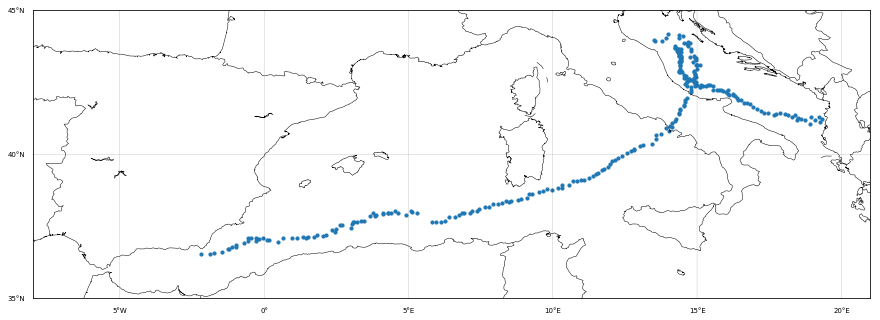

In [20]:
fig = plt.figure(figsize=(15, 15))

bmap.scatter(traiettoria[:,1],traiettoria[:,2], s=10)
bmap.drawcoastlines(linewidth=0.5, linestyle='solid', color='black')
bmap.drawcountries(linewidth=0.5, linestyle='solid', color='black')
bmap.drawparallels(np.arange(-90.0, 90.0, 5.), linewidth=0.2, color='black',
                       labels=[True, False, False, True], fontsize=7)
bmap.drawmeridians(np.arange(0.0, 360.0, 5.), linewidth=0.2, color='black',
                       labels=[True, False, False, True], fontsize=7)

plt.show()

In [7]:
import scipy.interpolate as interp
def interpolate_polyline(polyline, num_points):
    duplicates = []
    for i in range(1, len(polyline)):
        if np.allclose(polyline[i], polyline[i-1]):
            duplicates.append(i)
    if duplicates:
        polyline = np.delete(polyline, duplicates, axis=0)
    tck, u = interp.splprep(polyline.T, s=0)
    u = np.linspace(0.0, 1.0, num_points)
    return np.column_stack(interp.splev(u, tck))

In [25]:
traiettoria_interpolata = interpolate_polyline(traiettoria[:,1:3], 30)

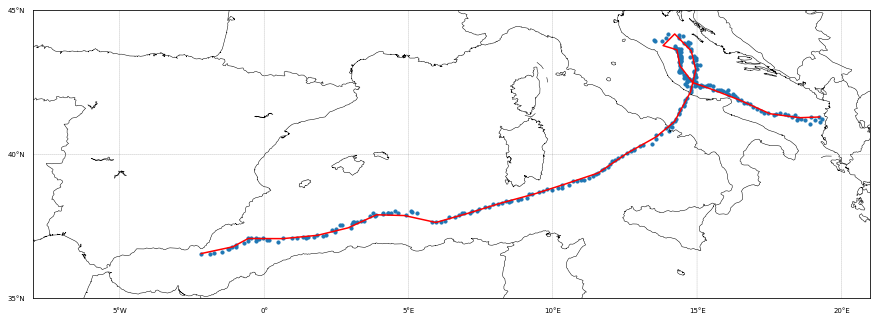

In [26]:
fig = plt.figure(figsize=(15, 15))

bmap.scatter(traiettoria[:,1],traiettoria[:,2], s=10)
bmap.plot(traiettoria_interpolata[:,0],traiettoria_interpolata[:,1], color='red')
bmap.drawcoastlines(linewidth=0.5, linestyle='solid', color='black')
bmap.drawcountries(linewidth=0.5, linestyle='solid', color='black')
bmap.drawparallels(np.arange(-90.0, 90.0, 5.), linewidth=0.2, color='black',
                       labels=[True, False, False, True], fontsize=7)
bmap.drawmeridians(np.arange(0.0, 360.0, 5.), linewidth=0.2, color='black',
                       labels=[True, False, False, True], fontsize=7)

plt.show()